# BGS Archetypes

The goal of this notebook is to derive a set of spectral archetypes from the BGS template set using Guangtun Zhu's [SetCoverPy](https://github.com/guangtunbenzhu/SetCoverPy) algorithm.

### Preliminaries.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from desispec.io.util import write_bintable, makepath
from desisim.io import write_templates
from desisim.archetypes import compute_chi2, ArcheTypes

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

#### Initialize the random seed so the results are reproducible, below.

In [5]:
seed = 123
rand = np.random.RandomState(seed)

#### Output path and filenames.

In [6]:
version = 'v1.0'

In [7]:
outdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'templates', 'archetypes', 'bgs', version)
print('Setting output directory to {}'.format(outdir))
os.makedirs(outdir, exist_ok=True)
chi2file = os.path.join(outdir, 'bgs_archetypes_chi2_{}.fits'.format(version))
archfile = os.path.join(outdir, 'bgs_archetypes_{}.fits'.format(version))

Setting output directory to /Users/ioannis/work/desi/spectro/templates/archetypes/bgs/v1.0


### Read the BGS basis templates.

Read both a set of lower-resolution (1 A/pix) templates sampled over a restricted wavelength range (roughly 3500-7000 A) and the same set at higher resolution (0.2 A/pix) and over the wavelength range 0.12-2 micron.  The lower-resolution templates will be used to determine the archetypes (since speed is an issue) while the full-resolution templates is what we actually write out.

In both cases we (arbitrarily) normalize every template to *r=18* and adopt a nominal velocity dispersion of 100 km/s.

In [8]:
def _build_templates(args):
    """Filler function for the multiprocessing."""
    build_templates(*args)

In [9]:
def build_templates(bgs, input_meta, verbose=False):
    flux, _, meta = bgs.make_templates(input_meta=input_meta, novdisp=True,
                                          nocolorcuts=True, verbose=verbose)
    return [flux.astype('f4'), meta]

In [10]:
def read_and_normalize(verbose=False, nproc=1, minwave=1200, maxwave=2e4, 
                       cdelt=0.2, nominal_rmag=18.0, nominal_vdisp=1000):
    """Read and normalize the full set of basis templates.
    
    """
    from astropy.table import vstack
    from desisim.templates import BGS
    from desisim.io import empty_metatable

    bgs = BGS(minwave=minwave, maxwave=maxwave, cdelt=cdelt)
    bgs.normline = None # no emission line
    
    nspec = len(bgs.basemeta)
    if False:
        nspec = 500 # 1000
        print('Hack! Selecting just {} / {} templates!'.format(nspec, len(bgs.basemeta)))
    these = np.arange(nspec)
    
    input_meta = empty_metatable(nmodel=nspec, objtype='BGS')
    input_meta['TEMPLATEID'] = these
    input_meta['REDSHIFT'] = 0.0
    input_meta['MAG'] = nominal_rmag
    input_meta['VDISP'] = nominal_vdisp
    input_meta['SEED'] = rand.randint(2**32, size=nspec)

    # Not sure why multiprocessing isn't working in this case.
    if nproc > 1:
        chunk = np.array_split(these, nproc)
    
        tempargs = list()
        for ii in range(nproc):
            tempargs.append((bgs, input_meta[chunk[ii]], verbose))
        
        pool = multiprocessing.Pool(nproc)
        out = pool.map(_build_templates, tempargs)
        flux = np.vstack(out[0])
        meta = vstack(out[1])
    else:
        flux, meta = build_templates(bgs, input_meta, verbose)

    nspec, npix = flux.shape
    print('Generated {} rest-frame BGS spectra with {} pixels.'.format(nspec, npix))
    
    return flux, bgs.wave, meta, bgs.basemeta[these]

In [11]:
%time flux, wave, meta, basemeta = read_and_normalize(nproc=1, cdelt=1.0, minwave=3600, maxwave=7000)
nspec, npix = flux.shape

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
Generated 7636 rest-frame BGS spectra with 3401 pixels.
CPU times: user 1min 14s, sys: 1.93 s, total: 1min 16s
Wall time: 1min 19s


In [12]:
%time hiresflux, hireswave, _, _ = read_and_normalize(nproc=1, cdelt=0.2, minwave=1200, maxwave=2e4)
_, hiresnpix = hiresflux.shape

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
Generated 7636 rest-frame BGS spectra with 94001 pixels.
CPU times: user 4min 15s, sys: 35.4 s, total: 4min 51s
Wall time: 4min 56s


In [13]:
def plot_subset(nplot=25, ncol=5):
    """Plot a random sampling of the basis templates."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    fig, ax = plt.subplots(nrow, ncol, figsize=(2.2*ncol, 2.2*nrow), sharey=True, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :])
        thisax.text(0.95, 0.93, '{:0d}'.format(indx), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

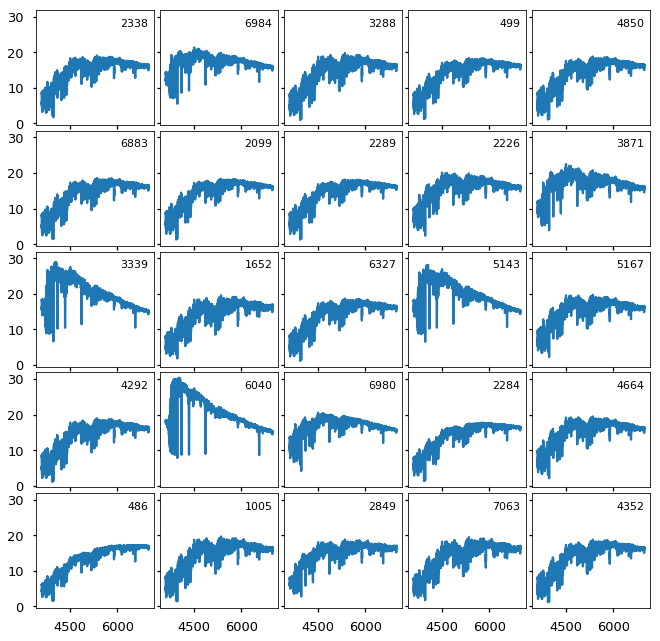

In [14]:
plot_subset()

### Compute the NxN chi2 matrix.

We use chi2 as the "distance" matrix for the Set Cover problem.  

Then, we need to determine what threshold chi2 value differentiates "different" templates.  

Note that the threshold chi^2 value can be tuned until the desired number of archetypes is achieved.  However, If we want the archetypes to describe each spectrum in the parent sample to a precision of prec=0.1 (10%) then we we should set chi2min to be approximately npix*prec^2.

In [15]:
def write_chi2(chi2):
    from astropy.io import fits
    print('Writing {}'.format(chi2file))
    hdu = fits.PrimaryHDU(chi2)
    hdu.writeto(chi2file, overwrite=True)

In [16]:
%time chi2, amp = compute_chi2(flux)

INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computing chi2 matrix for spectra 0-0 out of 7636.
INFO:archetypes.py:49:compute_chi2: Computi

In [17]:
write_chi2(chi2)

Writing /Users/ioannis/work/desi/spectro/templates/archetypes/bgs/v1.0/bgs_archetypes_chi2_v1.0.fits


In [18]:
prec = 0.1
chi2min_nominal = npix*prec**2
print(chi2min_nominal, np.log10(chi2min_nominal)) # seems high...

34.010000000000005 1.53160663193


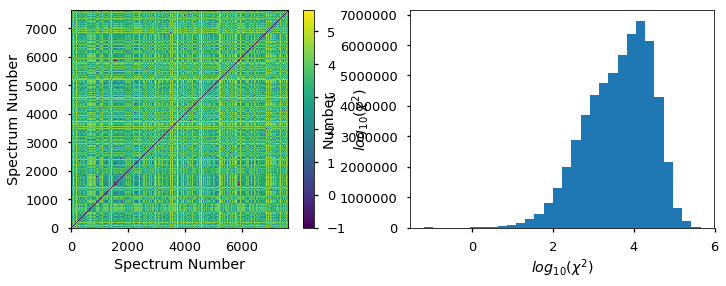

In [19]:
with np.errstate(divide='ignore'):
    logchi2 = np.log10(chi2)
logchi2[chi2 == 0] = -1
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
im = ax[0].imshow(logchi2, origin='lower', interpolation='nearest', 
                  vmin=-1.0, cmap='viridis')
ax[0].set_xlabel('Spectrum Number')
ax[0].set_ylabel('Spectrum Number')
plt.colorbar(im, label='$log_{10}(\chi^{2})$', ax=ax[0])

_ = ax[1].hist(logchi2.reshape(nspec * nspec), bins=30, range=(-1.2, np.max(logchi2)))
ax[1].set_ylabel('Number')
ax[1].set_xlabel('$log_{10}(\chi^{2}$)')

### Compute and plot the number of archetypes vs chi2 threshold.

In [20]:
def narch_vs_chi2min(Arch):
    """Determine the number of archtypes vs chi2 threshold.
    
    """
    cost = np.ones(nspec) # uniform cost
    chi2min = np.logspace(1, 5, 10)
    print(chi2min)
    narch = np.zeros_like(chi2min)
    
    for ii, cmin in enumerate(chi2min):
        iarch = Arch.get_archetypes(chi2_thresh=cmin)
        narch[ii] = len(iarch)
        
    return narch, chi2min

In [21]:
def qa_narch_vs_chi2min():
    fig, ax = plt.subplots()
    ax.scatter(np.log10(chi2min), narch)
    ax.set_xlabel('$log_{10}(\chi^{2})$ Threshold')
    ax.set_ylabel('Number of Archetypes')
    ax.axvline(x=np.log10(chi2min_nominal), color='red', ls='-')
    ax.grid(True)

In [22]:
Arch = ArcheTypes(chi2)

In [23]:
narch, chi2min = narch_vs_chi2min(Arch)

[  1.00000000e+01   2.78255940e+01   7.74263683e+01   2.15443469e+02
   5.99484250e+02   1.66810054e+03   4.64158883e+03   1.29154967e+04
   3.59381366e+04   1.00000000e+05]
This Best solution: UB=1970.0, LB=-11994.269286779563, UB1=1970.0, LB1=-11994.269286779563
Current Best Solution: UB=1970.0, LB=-11994.269286779563, change=708.8461566893179% @ niters=0
Current Best Solution: UB=1970.0, LB=1970.000022630492, change=-1.14875593464077e-06% @ niters=2
Final Best solution: 1970.0
Took 13.815 minutes to reach current solution.
This Best solution: UB=1104.0, LB=-49855.931378541194, UB1=1104.0, LB1=-49855.931378541194
Current Best Solution: UB=1104.0, LB=-49855.931378541194, change=4615.935813273659% @ niters=0


KeyboardInterrupt: 

In [ ]:
qa_narch_vs_chi2min()

### Choose a chi2 threshold value then get the final set of archetypes.

In [ ]:
def write_archetypes():
    """ToDo: Write out the responsibility indices for each archetype."""
    from astropy.table import Column
    outmeta = meta[iarch]
    outmeta.add_column(Column(name='RESPONSIBILITY', length=len(iarch), dtype='int8'))
    outmeta['RESPONSIBILITY'] = resp
    print('Writing {}'.format(archfile))
    write_templates(archfile, hiresflux[iarch, :], hireswave, outmeta, objtype='BGS Archetypes')    

In [ ]:
chi2_thresh = 10**3.5
print('Choosing a log10(chi2) threshold value of {:.1f}.'.format(np.log10(chi2_thresh)))

In [ ]:
_iarch, _resp, _respindx = Arch.get_archetypes(chi2_thresh=chi2_thresh, responsibility=True)
print('Generated {} archetypes.'.format(len(_iarch)))

#### Sort by Dn(4000).

In [ ]:
srt = np.argsort(meta['D4000'][_iarch])
iarch = _iarch[srt]
resp = _resp[srt]
respindx = []
for ss in srt:
    respindx.append(_respindx[ss])

In [ ]:
write_archetypes()

### Generate some QAplots.

In [ ]:
def _markers():
    d4000 = meta['D4000']
    size = 110 * (1+(resp - resp.min()) / resp.ptp())
    shade = (d4000[iarch] - d4000[iarch].min()) / d4000[iarch].ptp()
    col = plt.cm.coolwarm(shade)
    return size, col

In [ ]:
def qa_responsibility():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    rz = -2.5 * np.log10(meta['FLUX_R'] / meta['FLUX_Z'])
    d4000 = meta['D4000']

    size, col = _markers()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
    ax1.scatter(rz[iarch], resp, c=col, marker='o', s=size, 
                edgecolor='k')
    ax1.set_xlabel('r - z')
    ax1.set_ylabel('Responsibility')
    ax1.grid(True)

    ax2.scatter(d4000[iarch], resp, c=col, marker='o', s=size, 
               edgecolor='k')
    ax2.set_xlabel('$D_{n}(4000)$')
    ax2.grid(True)

    fig.subplots_adjust(wspace=0.05)

In [ ]:
qa_responsibility()

In [ ]:
def qa_colorcolor():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    gr = -2.5 * np.log10(meta['FLUX_G'] / meta['FLUX_R'])
    rz = -2.5 * np.log10(meta['FLUX_R'] / meta['FLUX_Z'])
    d4000 = meta['D4000']

    size, col = _markers()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.scatter(rz, gr, s=30, c='lightgray', edgecolor='k')
    ax1.scatter(rz[iarch], gr[iarch], c=col, marker='o', s=size, 
                alpha=1, edgecolor='k')
    ax1.set_xlabel(r'$r - z$')
    ax1.set_ylabel(r'$g - r$')
    ax1.grid(True)

    ax2.scatter(d4000, rz, s=30, c='lightgray', edgecolor='k')
    ax2.scatter(d4000[iarch], rz[iarch], c=col, marker='o', s=size, 
                alpha=1, edgecolor='k')
    ax2.set_xlabel('$D_{n}(4000)$')
    ax2.set_ylabel(r'$g - r$')
    ax2.grid(True)

    fig.subplots_adjust(wspace=0.3)

In [ ]:
qa_colorcolor()

In [ ]:
def qa_archetypes(ncol=5):
    """Plot the archetypes and the spectra for which they're responsible."""
    from scipy.ndimage.filters import gaussian_filter1d
    _, col = _markers()
    
    narch = len(iarch)
    nrow = np.ceil(narch / ncol).astype('int')
    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2.5*nrow), sharey=True, sharex=True)
    for jj, (thisax, indx, rindx, rr) in enumerate(zip(ax.flat, iarch, respindx, resp)):
        if rr > 1:
            for ii in rindx:
                thisax.plot(hireswave, hiresflux[ii, :], color='lightgrey')
        thisax.plot(hireswave, gaussian_filter1d(hiresflux[indx, :], 30), color=col[jj])
        thisax.xaxis.set_major_locator(plt.MaxNLocator(2))
        thisax.text(0.95, 0.93, '{:04d}\nResp={}'.format(indx, rr), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)    

In [ ]:
qa_archetypes()

In [ ]:
def qa_ages_colormag():
    """Generate a color-magnitude plot for the original AGES sample.
    
    """
    Mr = basemeta['SDSS_UGRIZ_ABSMAG_Z01'][:, 2]
    gr = basemeta['SDSS_UGRIZ_ABSMAG_Z01'][:, 1]-basemeta['SDSS_UGRIZ_ABSMAG_Z01'][:, 2]
    size, col = _markers()

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(Mr, gr, s=30, c='lightgray', edgecolor='k')
    ax.scatter(Mr[iarch], gr[iarch], c=col, marker='o', s=size, 
                alpha=1, edgecolor='k')
    ax.set_xlabel(r'$M_{0.1r}$')
    ax.set_ylabel(r'$^{0.1}(g - r)$')
    ax.set_xlim(-16, -23)
    ax.set_ylim(0, 1.3)
    
    ax.grid(True)

In [ ]:
qa_ages_colormag()